In [ ]:
pip install torch torchvision matplotlib


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.40MB/s]


SimpleAE | Epoch [1/5], Loss: 0.0501
SimpleAE | Epoch [2/5], Loss: 0.0211
SimpleAE | Epoch [3/5], Loss: 0.0154
SimpleAE | Epoch [4/5], Loss: 0.0128
SimpleAE | Epoch [5/5], Loss: 0.0114
DeepAE | Epoch [1/5], Loss: 0.0445
DeepAE | Epoch [2/5], Loss: 0.0199
DeepAE | Epoch [3/5], Loss: 0.0150
DeepAE | Epoch [4/5], Loss: 0.0124
DeepAE | Epoch [5/5], Loss: 0.0108


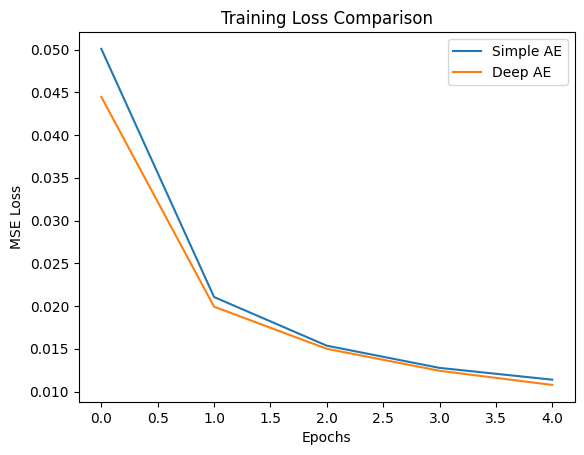

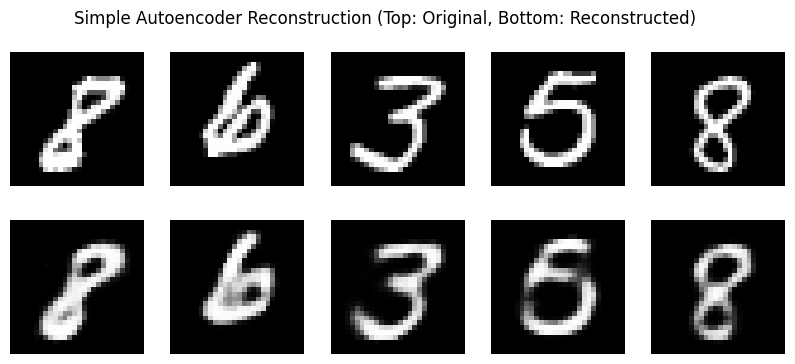

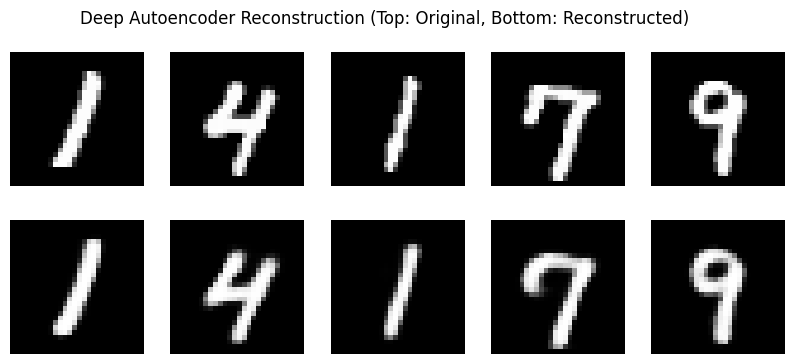

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tf = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='data', train=True, transform=tf, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
class SimpleAE(nn.Module):
    def __init__(self):
        super(SimpleAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(-1, 28*28)
        z = self.encoder(x)
        out = self.decoder(z)
        return out.view(-1, 1, 28, 28)
class DeepAE(nn.Module):
    def __init__(self):
        super(DeepAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(-1, 784)
        z = self.encoder(x)
        out = self.decoder(z)
        return out.view(-1, 1, 28, 28)
simpleAE = SimpleAE().to(device)
deepAE = DeepAE().to(device)
criterion = nn.MSELoss()
opt_simple = optim.Adam(simpleAE.parameters(), lr=1e-3)
opt_deep = optim.Adam(deepAE.parameters(), lr=1e-3)
def train_model(model, optimizer, name):
    losses = []
    for epoch in range(5):
        total_loss = 0
        for imgs, _ in train_loader:
            imgs = imgs.to(device)
            out = model(imgs)
            loss = criterion(out, imgs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg = total_loss / len(train_loader)
        losses.append(avg)
        print(f"{name} | Epoch [{epoch+1}/5], Loss: {avg:.4f}")
    return losses
loss_simple = train_model(simpleAE, opt_simple, "SimpleAE")
loss_deep = train_model(deepAE, opt_deep, "DeepAE")
plt.plot(loss_simple, label='Simple AE')
plt.plot(loss_deep, label='Deep AE')
plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()
def show_reconstruction(model, name):
    model.eval()
    imgs, _ = next(iter(train_loader))
    imgs = imgs[:5].to(device)
    with torch.no_grad():
        recons = model(imgs)
    imgs, recons = imgs.cpu(), recons.cpu()
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(5):
        axes[0, i].imshow(imgs[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recons[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle(f"{name} Reconstruction (Top: Original, Bottom: Reconstructed)")
    plt.show()

show_reconstruction(simpleAE, "Simple Autoencoder")
show_reconstruction(deepAE, "Deep Autoencoder")
